In [ ]:
import os
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import pandas as pd
import skimage
from skimage.io import imread,imshow, imsave
from skimage.transform import resize
import matplotlib.pyplot as plt
import sys
from sklearn.model_selection import train_test_split
import cv2

In [4]:
# users need to just select dimension and channel
dimension = 256
channel = 3

In [5]:
DATA_DIR = '../data/'
REL_IMAGE_PATH = os.path.join(DATA_DIR, "images-"+str(dimension))
REL_MASK_PATH = os.path.join(DATA_DIR, "masks-"+str(dimension))

IMAGE_TRAIN_PATH  = os.path.join(REL_IMAGE_PATH, "train")
IMAGE_TEST_PATH  = os.path.join(REL_IMAGE_PATH, "test")

MASK_TRAIN_PATH = os.path.join(REL_MASK_PATH, "train")
MASK_TEST_PATH = os.path.join(REL_MASK_PATH, "test")

In [6]:
train_image_names = os.listdir(IMAGE_TRAIN_PATH)
test_image_names = os.listdir(IMAGE_TEST_PATH)

train_mask_names = os.listdir(MASK_TRAIN_PATH)
test_mask_names = os.listdir(MASK_TEST_PATH)

In [21]:
width = dimension
height = dimension
# #to create X and Y arrays to be later filled with images of both images and masks
x_train = np.zeros((len(train_image_names),height,width,channel),dtype = np.uint8)
y_train = np.zeros((len(train_mask_names),height,width,1),dtype = np.uint8)

In [40]:
if os.path.isdir(IMAGE_TRAIN_PATH):
    i = 0
    for image_name in train_image_names:
        if i == 2:
            continue
        image_path = os.path.join(IMAGE_TRAIN_PATH, image_name)
        img = imread(image_path)[:,:,:channel]
        x_train[i] = resize(img,(height,width),mode ='edge',preserve_range =True)
        
        mask_path = os.path.join(MASK_TRAIN_PATH, image_name[:-4]+"_mask.png")
        mask = imread(mask_path)
        mask_resized = resize(mask, (height,width), mode ='edge', preserve_range = True)
        mask = np.expand_dims(mask_resized, axis=-1)
        y_train[i] = mask
        
        i += 1
else:
    print("There is no folder: "+img_output_loc+". Please build the data-set using BuildNewDataSet notebook.")

bef (256, 256)
(256, 256, 1)
bef (256, 256)
(256, 256, 1)


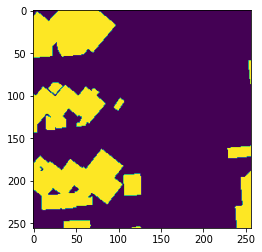

In [34]:
plt.imshow(round_image_with_threshold(np.squeeze(y_train[6]), 0))

In [27]:
a = np.squeeze(y_train[6])
np.unique(a.flatten())

array([  0,   1,   4,   5,   6,   7,  10,  11,  12,  13,  14,  17,  18,
        19,  23,  24,  25,  27,  31,  37,  61,  62,  63,  64,  67,  68,
        69,  73,  74,  75,  76,  80,  81,  82,  83,  87,  88,  94, 112,
       113, 118, 119, 120, 124, 125, 126, 127, 131, 132, 133, 137, 138,
       139, 144, 145, 150, 151, 163, 169, 170, 171, 172, 175, 176, 177,
       178, 182, 183, 184, 188, 189, 190, 195, 196, 197, 202, 203, 220,
       225, 226, 227, 228, 232, 233, 234, 238, 239, 240, 241, 242, 245,
       246, 247, 248, 251, 252, 253, 254, 255], dtype=uint8)

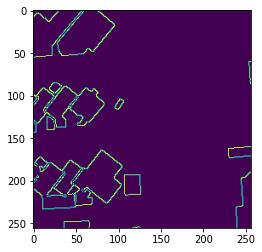

In [37]:
canny2 = cv2.Canny(a, 220, 250)
plt.imshow(canny2)

In [38]:
canny2.shape

(256, 256)

In [28]:
def round_image_with_threshold(image, threshold):
    flat_img = image.flatten()
    flat_img_round = [0 if v < threshold  else 1 for v in flat_img]
    round_img = np.reshape(flat_img_round, image.shape)
    return round_img

In [7]:
x_train_1 = x_train[:10]
y_train_1 = y_train[:10]

In [8]:
def jaccard_distance(y_true, y_pred, smooth=100):
    #""" Calculates mean of Jaccard distance as a loss function """
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1,2))
    sum_ = tf.reduce_sum(y_true + y_pred, axis=(1,2))
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    jd =  (1 - jac) * smooth
    return tf.reduce_mean(jd)

In [9]:
#creating U-Net architecture
def create_model(width, height, channel, loss, metric):
    inputs = tf.keras.layers.Input((width,height,channel))
    s = tf.keras.layers.Lambda(lambda x : x/255)(inputs)
    c1 = tf.keras.layers.Conv2D(16,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(s)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

    c2 = tf.keras.layers.Conv2D(32,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

    c3 = tf.keras.layers.Conv2D(64,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

    c4 = tf.keras.layers.Conv2D(128,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c4)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)


    c5 = tf.keras.layers.Conv2D(256,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c5)


    u6 = tf.keras.layers.Conv2DTranspose(128,(2,2),strides = (2,2),padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6,c4])
    c6 = tf.keras.layers.Conv2D(128,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(u6)
    c6 = tf.keras.layers.Dropout(0.3)(c6)
    c6 = tf.keras.layers.Conv2D(128,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64,(2,2),strides = (2,2),padding = 'same')(c6)
    u7 = tf.keras.layers.concatenate([u7,c3])
    c7 = tf.keras.layers.Conv2D(64,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32,(2,2),strides = (2,2),padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8,c2])
    c8 = tf.keras.layers.Conv2D(32,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(64,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16,(2,2),strides = (2,2),padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9,c1],axis = 3)
    c9 = tf.keras.layers.Conv2D(16,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c9)

    outputs = tf.keras.layers.Conv2D(1,(1,1),activation = "sigmoid")(c9)

    model = tf.keras.Model(inputs = [inputs],outputs = [outputs])
    model.compile(optimizer = 'adam',loss = loss,metrics = [metric])
    #model.summary()
    return model

In [8]:
#creating U-Net architecture
inputs = tf.keras.layers.Input((width,height,channel))
s = tf.keras.layers.Lambda(lambda x : x/255)(inputs)
c1 = tf.keras.layers.Conv2D(16,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)


c5 = tf.keras.layers.Conv2D(256,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c5)


u6 = tf.keras.layers.Conv2DTranspose(128,(2,2),strides = (2,2),padding = 'same')(c5)
u6 = tf.keras.layers.concatenate([u6,c4])
c6 = tf.keras.layers.Conv2D(128,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(u6)
c6 = tf.keras.layers.Dropout(0.3)(c6)
c6 = tf.keras.layers.Conv2D(128,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64,(2,2),strides = (2,2),padding = 'same')(c6)
u7 = tf.keras.layers.concatenate([u7,c3])
c7 = tf.keras.layers.Conv2D(64,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32,(2,2),strides = (2,2),padding = 'same')(c7)
u8 = tf.keras.layers.concatenate([u8,c2])
c8 = tf.keras.layers.Conv2D(32,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(64,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16,(2,2),strides = (2,2),padding = 'same')(c8)
u9 = tf.keras.layers.concatenate([u9,c1],axis = 3)
c9 = tf.keras.layers.Conv2D(16,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c9)

outputs = tf.keras.layers.Conv2D(1,(1,1),activation = "sigmoid")(c9)

model = tf.keras.Model(inputs = [inputs],outputs = [outputs])
model.compile(optimizer = 'adam',loss = ['binary_crossentropy'],metrics = ['accuracy'])
model.summary()



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         lambda[0][0]                     
________________________________________________________________________________

In [11]:
#model = create_model(width, height, channel, 'cosine_similarity', 'accuracy')

In [ ]:
model_path="cosine_similarity_256x256-{epoch:02d}-{val_acc:.2f}.hdf5"
clbk = [tf.keras.callbacks.ModelCheckpoint(model_path, verbose= 1,save_best_only=True),
        tf.keras.callbacks.EarlyStopping(patience =2, monitor = 'val_acc', mode = 'min'),
        tf.keras.callbacks.TensorBoard(log_dir = "logs")]

results = model.fit(x_train[:10],y_train[:10], epochs=20,
                   verbose = 1,use_multiprocessing=True,
                   callbacks=clbk, validation_split=0.2)